In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# fix all the random seed
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.use_deterministic_algorithms(True)


# Created a simple RNN which fits a sie wave. 
The RNN, which differs from the conventional '1 input step 1 recurrent step' RNN schema, models a fixed-point equation. The RNN runs multiple recurrent steps on a single input step which gradually converge to a fixed point.

In [2]:

class FixedPointRNN(nn.Module):
  def __init__(self, hidden_dim):
    super(FixedPointRNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.rnn = nn.RNNCell(input_size=1, hidden_size=hidden_dim)
    self.output = nn.Linear(hidden_dim, 1)
    self.output_record = []

  def forward(self, x, num_iters):
    h_t = torch.zeros(x.size(0), self.hidden_dim)
    hidden_states = []  # List to store the hidden states
    for _ in range(num_iters):
        h_t = self.rnn(x, h_t)
        hidden_states.append(h_t.clone())  # Store a copy of the hidden state
        self.output_record = self.output(h_t).clone().detach().numpy()
    output = self.output(h_t)
    return output, torch.stack(hidden_states, dim=0)  # Return both output and hidden states


In [3]:
# Generate data
x_values = torch.linspace(-2 * np.pi, 2 * np.pi, 200).unsqueeze(1)  # 100 data points over one full sine wave cycle
y_values = torch.sin(x_values)  # Target sine values

In [4]:
# Define the model and optimizer
def train_model_with_fp_iters(iters, print_flag):
  model = FixedPointRNN(hidden_dim=20)
  num_iters = iters
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  spectral_norms = []
  eigenvalues = []
  lambda_reg = 0.5
  # Training loop
  for epoch in range(600):
    model.train()
    optimizer.zero_grad()
    outputs, hs = model(x_values, num_iters)

    # # Compute the spectral norm of weight_ih
    weight_hh = model.rnn.weight_hh
    _, S, _ = torch.svd(weight_hh)  # Compute the SVD
    spectral_norm = S[0]  # The largest singular value
    spectral_norms.append(spectral_norm.item())  # Store the spectral norm

    loss = criterion(outputs, y_values)

    # # Regularized loss
    if spectral_norm > 1:
      loss += lambda_reg * (spectral_norm - 1)  # Penalize only the excess over 1

    loss.backward()
    optimizer.step()

    if (epoch % 50 == 0) and print_flag:
      eigvals = np.linalg.eigvals(weight_hh.detach().numpy())
      eigenvalues.append(eigvals)
      print(f"Epoch {epoch}, Loss: {loss.item()}, Spectral Norm: {spectral_norm.item()}")

  return model

num_iters = 15
model = train_model_with_fp_iters(iters=num_iters, print_flag=True)

Epoch 0, Loss: 0.513573944568634, Spectral Norm: 1.119223713874817
Epoch 50, Loss: 0.05708106979727745, Spectral Norm: 0.9936107993125916
Epoch 100, Loss: 0.0359061174094677, Spectral Norm: 0.9890069961547852
Epoch 150, Loss: 0.0021810964681208134, Spectral Norm: 0.9925509691238403
Epoch 200, Loss: 0.0012817226815968752, Spectral Norm: 0.9741249084472656
Epoch 250, Loss: 0.002289911499246955, Spectral Norm: 0.9682480096817017
Epoch 300, Loss: 0.0006994929863139987, Spectral Norm: 0.9672274589538574
Epoch 350, Loss: 0.000698877323884517, Spectral Norm: 0.9485923051834106
Epoch 400, Loss: 0.004729724023491144, Spectral Norm: 0.964068591594696
Epoch 450, Loss: 0.0010246236342936754, Spectral Norm: 0.9280640482902527
Epoch 500, Loss: 4.758046634378843e-05, Spectral Norm: 0.9969145059585571
Epoch 550, Loss: 2.6335068469052203e-05, Spectral Norm: 0.9979647994041443


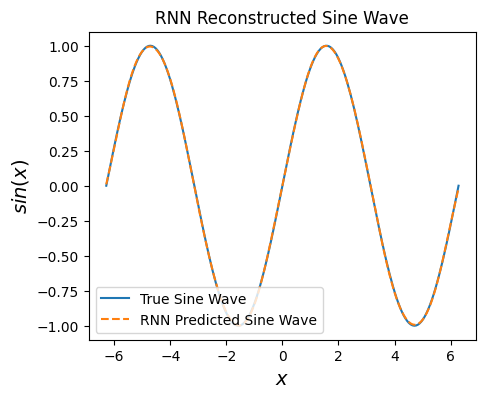

In [5]:
# Evaluate
model.eval()
with torch.no_grad():
  predicted_sine_wave, hidden_states = model(x_values, num_iters)
  # Convert hidden states to a numpy array for PCA
plt.figure(figsize=(5, 4))
plt.plot(x_values.numpy(), y_values.numpy(), label='True Sine Wave')
plt.plot(x_values.numpy(), predicted_sine_wave.numpy(), label='RNN Predicted Sine Wave', linestyle='--')
plt.title('RNN Reconstructed Sine Wave')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$sin(x)$', fontsize=14)
plt.legend(loc='lower left')
plt.show()

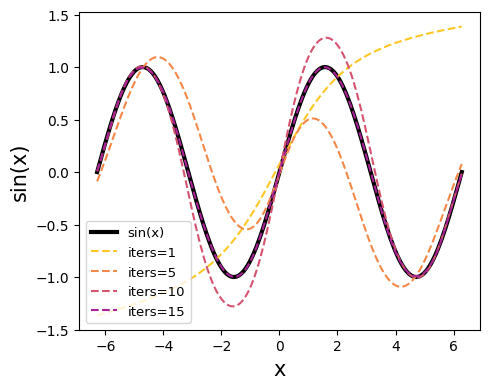

In [6]:
# also plot RNN with different inference num_iters
plt.figure(figsize=(5, 4))
plt.plot(x_values.numpy(), y_values.numpy(), label='sin(x)', color='black', linewidth=3)
colors = plt.cm.plasma(np.linspace(0.2, 1.0, 15))
with torch.no_grad():
  color_counter = 0
  for num_iter in [1, 5, 10, 15]:
    color_counter += 3
    predicted_sine_wave, _ = model(x_values, num_iter)
    plt.plot(x_values.numpy(), predicted_sine_wave.numpy(), label=f'iters={num_iter}',\
              linestyle='--', color = colors[-color_counter])

plt.xlabel('x', fontsize=15)
plt.ylabel('sin(x)', fontsize=15)
# make the icon in the legend smaller 
plt.legend(loc='lower left', prop={'size': 9.5}, ncol=1)
plt.tight_layout()
plt.show()


# PCA analysis on the hidden states

hidden states shape:(75, 20)


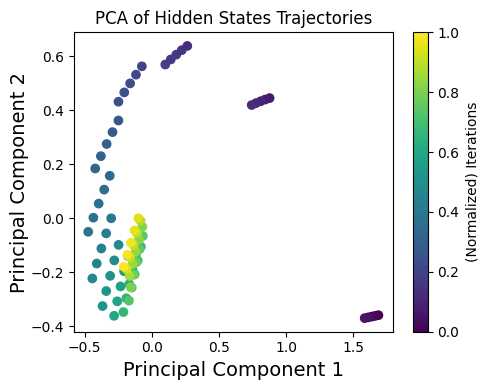

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import random
model.eval()
x_values = torch.linspace(-2 * np.pi, 2 * np.pi, 200).unsqueeze(1)
x_value = x_values[50:55] # pick 5 closeby points to see how their hidden states co-evolved

with torch.no_grad():
  predicted_sine_wave, hidden_states = model(x_value, num_iters)
  hidden_states_np = hidden_states.detach().numpy().reshape(-1, model.hidden_dim)
  print(f"hidden states shape:{hidden_states_np.shape}")  # (5*15, 20)

# Perform PCA
pca = PCA(n_components=2)  # Reduce dimensions to 2 for visualization
principal_components = pca.fit_transform(hidden_states_np)

# Plot the first two principal components
plt.figure(figsize=(5, 4))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=np.linspace(0, 1, num=hidden_states_np.shape[0]), cmap='viridis')
# remove ticks on the colorbar
plt.colorbar(label='(Normalized) Iterations', location='right')
# set the colorbard closer to the figure

plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
# set_label_coords closer to the axis
plt.gca().yaxis.set_label_coords(-0.14, 0.5)
plt.title('PCA of Hidden States Trajectories')
plt.tight_layout()
plt.show()

In [8]:
model.eval()

x_value = x_values
with torch.no_grad():
  predicted_sine_wave, hidden_states = model(x_value, num_iters)
  hidden_states_np = hidden_states.detach().numpy().reshape(-1, model.hidden_dim)

# Assume hidden_states_np is the numpy array of hidden states reshaped as mentioned previously
pca_full = PCA()  # Compute PCA without specifying n_components to get all components
pca_full.fit(hidden_states_np)

# Calculate the explained variance ratio for each component
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

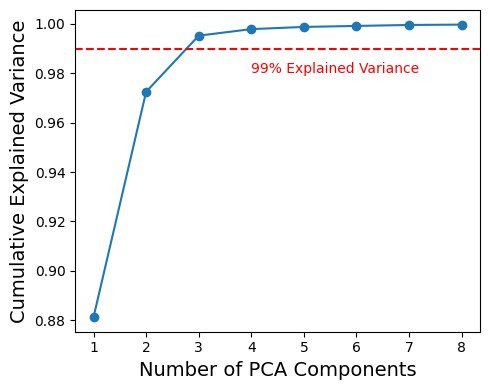

In [9]:
plt.figure(figsize=(5, 4))
show_top_k = 8
plt.plot(range(1, show_top_k + 1), cumulative_explained_variance[:show_top_k], marker='o', linestyle='-')
plt.xlabel('Number of PCA Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)

plt.xticks(range(1, show_top_k + 1, 1))  # Setting x-ticks to integer values
plt.axhline(y=0.99, color='r', linestyle='--')  # Optional: 95% variance line
plt.text(show_top_k*0.5, 0.98, '99% Explained Variance', color = 'red')
plt.tight_layout()
plt.show()

# inference on one point in the training set.


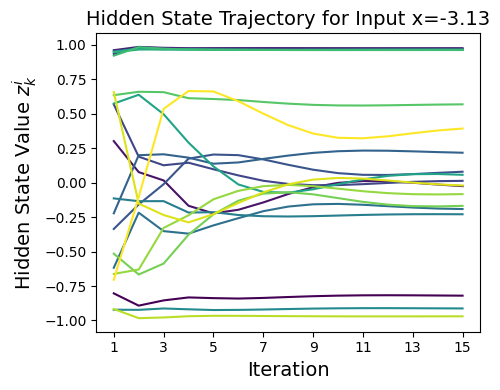

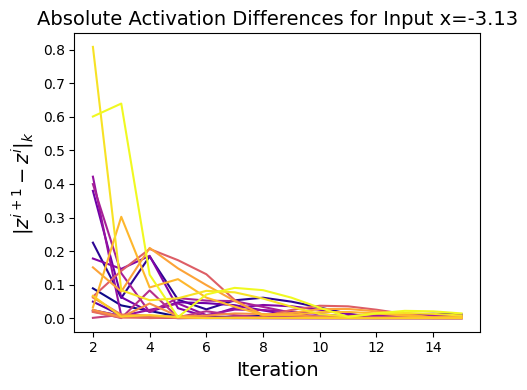

In [13]:
# Model and input setup
value = x_values[50].item() # pick different values to see how hidden states evolve
x_value = torch.tensor([[value]])  # Example input value x = pi
y_value = np.sin(x_value)
# Collect hidden states
model.eval()
with torch.no_grad():
  _, hidden_states = model(x_value, num_iters)  # Assuming the forward method returns outputs and hidden states

# Convert hidden states to numpy array for easier handling in plotting
hidden_states_np = hidden_states.numpy()  # Shape will be [num_iters, 1, hidden_dim]

# Reshape for easier plotting: flatten out over iterations
hidden_states_np = hidden_states_np.squeeze()  # Removes the middle dimension since we have one sample

plt.figure(figsize=(5, 4))
num_iters, hidden_dim = hidden_states_np.shape
colors = plt.cm.viridis(np.linspace(0, 1, hidden_dim))
for i in range(hidden_dim):
    plt.plot(range(1, num_iters+1), hidden_states_np[:, i], label=f'Component {i+1}', color = colors[i])

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Hidden State Value $z^{i}_{k}$', fontsize=14)
plt.title(f'Hidden State Trajectory for Input x={value:.2f}', fontsize=14)
plt.xticks(range(1, num_iters+1, 2), size=10)
plt.tight_layout()
plt.show()


# Calculate absolute differences
diffs = np.abs(np.diff(hidden_states_np, axis=0))

# Set up plot
plt.figure(figsize=(5, 4))
diff_num_iters, hidden_dim = diffs.shape
colors = plt.cm.plasma(np.linspace(0, 1, hidden_dim))
for i in range(hidden_dim):
    plt.plot(range(2, num_iters+1), diffs[:, i], label=f'Component {i+1} Difference', color = colors[i])

# Configure plot settings
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$|z^{i+1} - z^{i}|_{k}$', fontsize=14)
plt.xticks(range(2, num_iters+1, 2), size=10)
plt.title(f'Absolute Activation Differences for Input x={value:.2f}', fontsize=14)
plt.tight_layout()
plt.show()

#inference on randomly sampled points and get the mean and variance

all_diffs.shape:(1000, 14, 20)
mean_diffs shape:(14, 20)


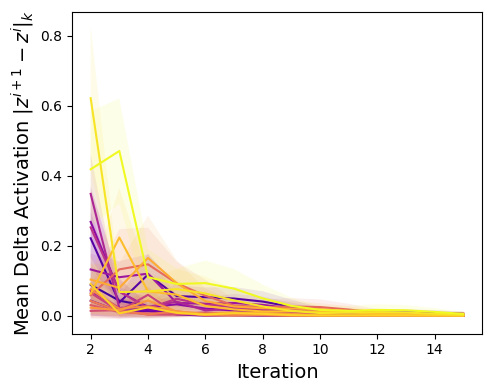

In [14]:
# Assuming x_values is an iterable of input values
model.eval()
all_hidden_states = []
all_diffs = []

x_values = np.random.uniform(-2 * np.pi, 2 * np.pi, 1000)
# Perform inference on each input value
for value in x_values:
    x_value = torch.tensor([[value.item()]], dtype=torch.float32)
    with torch.no_grad():
        _, hidden_states = model(x_value, num_iters)

    # Convert hidden states to numpy and store
    hidden_states_np = hidden_states.squeeze().numpy()
    all_hidden_states.append(hidden_states_np)

    # Calculate and store differences
    diffs = np.abs(np.diff(hidden_states_np, axis=0))
    all_diffs.append(diffs)

# Convert lists to numpy arrays for easier manipulation
all_hidden_states = np.array(all_hidden_states)  # Shape: [num_samples, num_iters, hidden_dim]
all_diffs = np.array(all_diffs)  # Shape: [num_samples, num_iters-1, hidden_dim]
print(f"all_diffs.shape:{all_diffs.shape}")
# Calculate mean and variance across all input samples
mean_activations = np.mean(all_hidden_states, axis=0)
variance_activations = np.var(all_hidden_states, axis=0)
mean_diffs = np.mean(all_diffs, axis=0)
print(f"mean_diffs shape:{mean_diffs.shape}")
variance_diffs = np.var(all_diffs, axis=0)

# Plotting mean and variance for activation differences
plt.figure(figsize=(5, 4))
colors = plt.cm.plasma(np.linspace(0.1, 1.0, mean_diffs.shape[1]))
for i in range(mean_diffs.shape[1]):
    std_deviation = np.sqrt(variance_diffs[:, i])
    plt.plot(range(2, num_iters+1), mean_diffs[:, i], color=colors[i])
    plt.fill_between(range(2, num_iters+1), mean_diffs[:, i] - std_deviation, mean_diffs[:, i] + std_deviation, facecolor=colors[i], edgecolor='none',alpha=0.1)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean Delta Activation $|z^{i+1} - z^{i}|_{k}$', fontsize=14)
# move the y label a bit lower
plt.gca().yaxis.set_label_coords(-0.085,0.5)

plt.tight_layout()
plt.show()

# Converged number of dimensions at i-th recurrent step and the corresnponding MSE at i-th recurrent step.

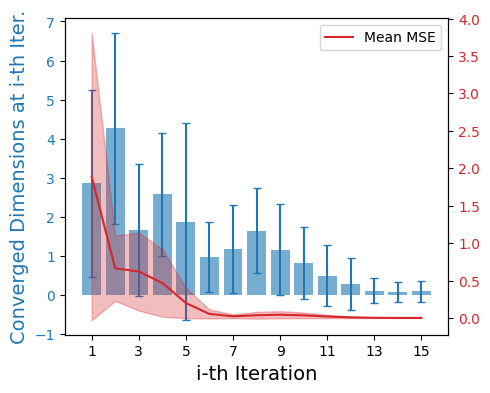

In [17]:
# sample 100 random values between -2pi and 2pi
x_values = torch.Tensor(np.random.uniform(-2 * np.pi, 2 * np.pi, 1000))

y_values = torch.sin(x_values)  # Target sine values
model.eval()
all_convergence_steps_hist = []
all_convergence_steps_bins = []
all_mse = []
epsilon = 0.01 # Convergence threshold

# Loop over all input values
for value in x_values:
    x_value = torch.tensor([[value.item()]], dtype=torch.float32)
    y_true = torch.sin(x_value)  # Assuming y_true is consistent across iterations

    with torch.no_grad():
        _, hidden_states = model(x_value, num_iters)

    # Collect MSE for each iteration
    mse_per_input = []
    for i in range(num_iters):
        output = model.output(hidden_states[i]) 
        mse = (y_true - output) ** 2
        mse_per_input.append(mse.item())

    all_mse.append(mse_per_input)

    # Convert and reshape hidden states
    hidden_states_np = hidden_states.squeeze().numpy()  # Shape: [num_iters, hidden_dim]
    num_iters, hidden_dim = hidden_states_np.shape

    # Determine convergence steps for each dimension
    convergence_steps = np.full(hidden_dim, num_iters)
    for dim in range(hidden_dim):
        for i in range(1, num_iters):
            if np.abs(hidden_states_np[i, dim] - hidden_states_np[i-1, dim]) < epsilon:
                convergence_steps[dim] = i
                break

    hist, bins = np.histogram(convergence_steps, bins=np.arange(1, num_iters+2))
    all_convergence_steps_hist.append(hist)

# Convert lists to numpy arrays
all_mse = np.array(all_mse)
mean_mse = np.mean(all_mse, axis=0)
std_dev_mse = np.std(all_mse, axis=0)

all_convergence_steps_hist = np.array(all_convergence_steps_hist)

mean_convergence_steps_hist = np.mean(all_convergence_steps_hist, axis=0)
std_dev_convergence_steps = np.std(all_convergence_steps_hist, axis=0)

# Plotting
fig, ax1 = plt.subplots(figsize=(5, 4))

color = 'tab:blue'
ax1.set_xlabel('i-th Iteration', fontsize=14)
ax1.set_ylabel('Converged Dimensions at i-th Iter.', color=color, fontsize=14)

ax1.bar(bins[:-1], mean_convergence_steps_hist, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

bin_centers = bins[:-1]

# Add error bars for standard deviation
ax1.errorbar(bin_centers, mean_convergence_steps_hist, yerr=std_dev_convergence_steps, fmt='none', capsize=3, color=color, label='Standard Deviation')

# Create secondary y-axis for MSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('', color=color, fontsize=14)
ax2.plot(range(1, num_iters+1, 1), mean_mse, label='Mean MSE', color=color)
# put the line plot in the legend
ax2.legend(loc='upper right')

ax2.fill_between(range(1, num_iters+1, 1), mean_mse - std_dev_mse, mean_mse + std_dev_mse, color=color, alpha=0.3, label='MSE Std. Dev.')
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(range(1, num_iters+1, 2))
fig.tight_layout()
plt.show()